# Lab 2: LangGraph Components


## Setting Up the Environment

In [1]:
from dotenv import load_dotenv
import json
import os
import re
import sys
import warnings

import boto3
from botocore.config import Config

warnings.filterwarnings("ignore") # bor qua warning
import logging

# import local modules
dir_current = os.path.abspath("") # lay duong dan tuyet doi
dir_parent = os.path.dirname(dir_current)  
if dir_parent not in sys.path:
    sys.path.append(dir_parent) # Them duong dan tu muc du an
from utils import utils

# Set basic configs
logger = utils.set_logger()
pp = utils.set_pretty_printer()

# Load environment variables from .env file or Secret Manager
_ = load_dotenv("../.env")
aws_region = os.getenv("AWS_REGION")
tavily_ai_api_key = utils.get_tavily_api("TAVILY_API_KEY", aws_region)

# Set bedrock configs
bedrock_config = Config(
    connect_timeout=120, read_timeout=120, retries={"max_attempts": 0}
)

# Create a bedrock runtime client
bedrock_rt = boto3.client(
    "bedrock-runtime", region_name=aws_region, config=bedrock_config
)

# Create a bedrock client to check available models
bedrock = boto3.client("bedrock", region_name=aws_region, config=bedrock_config)


[2025-10-01 01:16:29,016] p3450 {utils.py:46} INFO - TAVILY_API_KEY variable correctly retrieved from the .env file.


## LangGraph as a State Machine

For solution architects familiar with system design, LangGraph can be thought of as a state machine for language models. Just as a state machine in software engineering defines a set of states and transitions between them, LangGraph allows us to define the states of our conversation (represented by nodes) and the transitions between them (represented by edges).

**Analogy**: Think of LangGraph as a traffic control system for a smart city. Each intersection (node) represents a decision point, and the roads between them (edges) represent possible paths. The traffic lights (conditional edges) determine which path to take based on current conditions. In our case, the "traffic" is the flow of information and decisions in our AI agent.


In [2]:
import operator
from typing import Annotated, TypedDict

from langchain_aws import ChatBedrockConverse
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import END, StateGraph

In [3]:
tool = TavilySearchResults(max_results=4)  # increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).


## The Agent State Concept

The AgentState class is crucial for maintaining context throughout the conversation. For data scientists, this can be compared to maintaining state in a recurrent neural network.

**Analogy**: Think of the AgentState as a sophisticated notepad. As you brainstorm ideas (process queries), you jot down key points (messages). This notepad doesn't just record; it has a special property where new notes (messages) are seamlessly integrated with existing ones, maintaining a coherent flow of thought.
At the same time, you can always go back in time and rewrite some parts of it - this is what we call "time-travel".


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name.

```python
if not t["name"] in self.tools:  # check for bad tool name from LLM
    print("\n ....bad tool name....")
    result = "bad tool name, retry"  # instruct LLM to retry if bad

```


In [21]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)   #  khoi tao graph
        graph.add_node("llm", self.call_bedrock)  # them llm vao node
        graph.add_node("action", self.take_action) # them action vao node
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )  # them trang thai thuc thi, neu exists_action thi den action, khong thi END
        graph.add_edge("action", "llm")  #action quay ve llm
        graph.set_entry_point("llm")  
        self.graph = graph.compile() # complie graph
        self.tools = {t.name: t for t in tools}  # danh sach tool trong 
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def call_bedrock(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t["name"] in self.tools:  # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t["name"]].invoke(t["args"])
            results.append(
                ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result))
            )
        print("Back to the model!")
        return {"messages": results}

An often overlooked feature is the `??` to inspect the code of a function or object in python.

Lets inspect the `bind_tools` method on the `ChatBedrockConverse` class.
Can you spot if our tavily tool will be supported, and if there are any restrictions?

If you are unsure, how would you check?


In [6]:
??ChatBedrockConverse.bind_tools

Signature:
ChatBedrockConverse.bind_tools(
    self,
    tools: Sequence[Union[Dict[str, Any], Type[pydantic.v1.main.BaseModel], Type[pydantic.main.BaseModel], Callable, langchain_core.tools.BaseTool]],
    *,
    tool_choice: Union[dict, str, Literal['auto', 'any'], NoneType] = None,
    **kwargs: Any,
) -> langchain_core.runnables.base.Runnable[typing.Union[langchain_core.prompt_values.PromptValue, str, typing.Sequence[typing.Union[langchain_core.messages.base.BaseMessage, typing.List[str], typing.Tuple[str, str], str, typing.Dict[str, typing.Any]]]], langchain_core.messages.base.BaseMessage]
Docstring: <no docstring>
Source:   
    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], TypeBaseModel, Callable, BaseTool]],
        *,
        tool_choice: Optional[Union[dict, str, Literal["auto", "any"]]] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        if tool_choice:
            kwargs["tool_choice"] = _format_tool_choic

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence).\
Whenever you can, try to call multiple tools at once, to bring down inference time!\
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatBedrockConverse(
    client=bedrock_rt,
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
)

abot = Agent(model, [tool], system=prompt)

/home/workshop/langgraph-agents-with-amazon-bedrock/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `ChatBedrockConverse` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


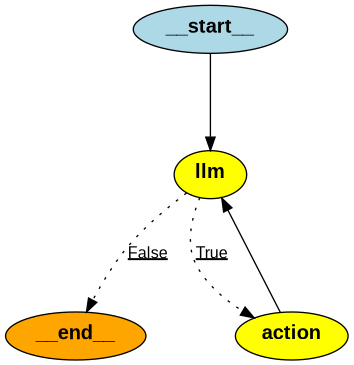

In [8]:
# make sure to install pygraphviz if you haven't done so already using 'conda install --channel conda-forge pygraphviz'
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [14]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': 'tooluse_hypyHIPoR-OBzuH7sy6UEw', 'type': 'tool_call'}
Back to the model!


In [15]:
for message in result["messages"]:
    print(f"{message}\n")

content='What is the weather in sf?'

content=[{'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'weather in san francisco'}, 'id': 'tooluse_hypyHIPoR-OBzuH7sy6UEw'}] response_metadata={'ResponseMetadata': {'RequestId': 'cc06c44b-00d7-4ae3-8b47-49367e813039', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 30 Sep 2025 18:34:34 GMT', 'content-type': 'application/json', 'content-length': '333', 'connection': 'keep-alive', 'x-amzn-requestid': 'cc06c44b-00d7-4ae3-8b47-49367e813039'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 1022}} id='run-766af846-5f78-4d16-b1b6-a0c7cead3cea-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': 'tooluse_hypyHIPoR-OBzuH7sy6UEw', 'type': 'tool_call'}] usage_metadata={'input_tokens': 459, 'output_tokens': 61, 'total_tokens': 520}

content='[{\'url\': \'https://en.climate-data.org/north-america/united-states-of-america/california/san-francisco-3

In [16]:
result["messages"][-1].content

'Based on the search results, the weather in San Francisco in September is generally mild and comfortable, with average high temperatures around 20-22°C (68-72°F) and average lows around 14-16°C (57-61°F). There is little to no rain during this time of year, with only a few days of light rain or drizzle expected. The city experiences mostly sunny or partly cloudy conditions, with around 9 hours of sunshine per day on average. Winds are moderate, typically around 13-15 km/h (8-9 mph). Overall, the weather in San Francisco in September is quite pleasant and ideal for exploring the city.'

In [17]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in san francisco'}, 'id': 'tooluse_x_JxrMNoRASUmguZpLwKPg', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in los angeles'}, 'id': 'tooluse_LYPiNzCySdiMbRGCTjDMWQ', 'type': 'tool_call'}
Back to the model!


In [18]:
result["messages"][-1].content

'Based on the search results, here is the weather summary for San Francisco and Los Angeles in September:\n\nSan Francisco:\n- Temperatures range from around 16-20°C (60-68°F) during the day and 13-16°C (55-60°F) at night.\n- There is a mix of weather, including some cloudy and rainy days, especially towards the end of the month.\n- Humidity levels are around 80-85%.\n- Wind speeds are moderate, around 13-15 km/h (8-9 mph).\n\nLos Angeles: \n- Temperatures are quite warm, ranging from around 24-31°C (75-89°F) during the day and 16-20°C (61-68°F) at night.\n- The weather is mostly sunny and dry, with little to no rain expected.\n- Humidity levels are in the 50-60% range.\n- Wind speeds are light, around 10 km/h (6 mph).\n\nSo in summary, San Francisco has a more moderate, mixed weather pattern, while Los Angeles enjoys warmer, sunnier and drier conditions in September.'

## 4. Parallel vs. Sequential Tool Calling

The ability of the agent to make both parallel and sequential tool calls is a powerful feature that solution architects should pay attention to.

**Deep Dive**:

- Parallel tool calling is like a multithreaded application, where multiple independent tasks can be executed simultaneously. This is efficient for queries that require multiple pieces of independent information.
- Sequential tool calling is more like a pipeline, where the output of one operation becomes the input of the next. This is necessary for multi-step reasoning tasks.

**Analogy**: Imagine a research team working on a complex project. Parallel tool calling is like assigning different team members to research different aspects simultaneously. Sequential tool calling is like a relay race, where each researcher builds on the findings of the previous one.

Can you spot if we will have sequential or parallel tool calls and if we have parallel, would they really be executed in parallel?


In [20]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatBedrockConverse(
    client=bedrock_rt,
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    temperature=0,
    max_tokens=None,
)
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 super bowl winner'}, 'id': 'tooluse_oRz2Yvi6SiOQgRFDpZSHEA', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'kansas city chiefs headquarters location'}, 'id': 'tooluse_tHJSbrVCSVSQ1ruO1vDFlg', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'missouri gdp'}, 'id': 'tooluse_D4km6CuVTuaO5QB7dKW0mQ', 'type': 'tool_call'}
Back to the model!


In [ ]:
print(result["messages"][-1].content)

# Exercise: How would you have to change the tool definition, to allow for parallel calling of the tool?

> Note: you can omit the parallel execution with async


In [ ]:
from langchain.tools import tool

@tool
async def my_tool(param: str) -> str:
    # Gọi API bất đồng bộ hoặc thao tác I/O
    return await some_async_operation(param)
